In [2]:
%load_ext autoreload
%autoreload 1
%aimport pygenesig.pybioqc
%aimport pygenesig.tools
%aimport pygenesig.file_formats
%matplotlib inline


from pygenesig.pybioqc import * 
from pygenesig.bioqc import * 
from pygenesig.tools import * 
from pygenesig.file_formats import * 
from scipy.stats import mannwhitneyu
import pandas as pd
from pylab import * 
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
exprs = read_expr("../pygenesig-example/data_processed/v6/exprs.npy")
target = read_target("../pygenesig-example/data_processed/v6/target.csv")
rosetta = read_rosetta("../pygenesig-example/data_processed/v6/rosetta.csv", inverse=True)

In [70]:
signatures = load_gmt("../pygenesig-example/results/gtex_v6_solid_gini_0.8_1/signatures.gmt")
signatures_ind = translate_signatures(signatures, rosetta, ignore_missing=True)
signatures_ind = {
    tissue: np.array(inds) for tissue, inds in signatures_ind.items()
}

In [71]:
target

array(['Adipose_Subcutaneous', 'Adipose_Subcutaneous',
       'Adipose_Subcutaneous', ..., 'Whole_Blood', 'Whole_Blood',
       'Whole_Blood'], 
      dtype='<U37')

In [310]:
target_name = {
    'tissue1': 'Liver',
    'tissue2': 'Uterus'
}

In [311]:
sig_name = {
    'tissue1': 'Liver',
    'tissue2': 'Uterus'
}

In [312]:
np.where(target == target_name['tissue1'])

(array([4789, 4790, 4791, 4792, 4793, 4794, 4795, 4796, 4797, 4798, 4799,
        4800, 4801, 4802, 4803, 4804, 4805, 4806, 4807, 4808, 4809, 4810,
        4811, 4812, 4813, 4814, 4815, 4816, 4817, 4818, 4819, 4820, 4821,
        4822, 4823, 4824, 4825, 4826, 4827, 4828, 4829, 4830, 4831, 4832,
        4833, 4834, 4835, 4836, 4837, 4838, 4839, 4840, 4841, 4842, 4843,
        4844, 4845, 4846, 4847, 4848, 4849, 4850, 4851, 4852, 4853, 4854,
        4855, 4856, 4857, 4858, 4859, 4860, 4861, 4862, 4863, 4864, 4865,
        4866, 4867, 4868, 4869, 4870, 4871, 4872, 4873, 4874, 4875, 4876,
        4877, 4878, 4879, 4880, 4881, 4882, 4883, 4884, 4885, 4886, 4887,
        4888, 4889, 4890, 4891, 4892, 4893, 4894, 4895, 4896, 4897, 4898,
        4899, 4900, 4901, 4902, 4903, 4904, 4905, 4906, 4907]),)

In [313]:
np.where(target == target_name['tissue2'])

(array([7983, 7984, 7985, 7986, 7987, 7988, 7989, 7990, 7991, 7992, 7993,
        7994, 7995, 7996, 7997, 7998, 7999, 8000, 8001, 8002, 8003, 8004,
        8005, 8006, 8007, 8008, 8009, 8010, 8011, 8012, 8013, 8014, 8015,
        8016, 8017, 8018, 8019, 8020, 8021, 8022, 8023, 8024, 8025, 8026,
        8027, 8028, 8029, 8030, 8031, 8032, 8033, 8034, 8035, 8036, 8037,
        8038, 8039, 8040, 8041, 8042, 8043, 8044, 8045, 8046, 8047, 8048,
        8049, 8050, 8051, 8052, 8053, 8054, 8055, 8056, 8057, 8058, 8059,
        8060, 8061, 8062, 8063, 8064, 8065]),)

In [314]:
s_ind = {
    'tissue1': np.flatnonzero(target == target_name['tissue1'])[0],
    'tissue2': np.flatnonzero(target == target_name['tissue2'])[0]
}
s_ind

{'tissue1': 4789, 'tissue2': 7983}

In [315]:
s = {
    tissue: exprs[:, i] for tissue, i in s_ind.items()
}

In [316]:
ind = {
    tissue: np.array([True if i in signatures_ind[name] else False for i in range(exprs.shape[0])])
    for tissue, name in sig_name.items()
}

In [332]:
rel_rk = {
    tissue: pd.DataFrame(exprs[:, target == target_name[tissue]]).rank(
        axis=0, ascending=False).iloc[ind[tissue], :].median(axis=0).median() / exprs.shape[0] for tissue in s
}
rel_rk

{'tissue1': 0.02013380854123679, 'tissue2': 0.09816794847745888}

In [333]:
size = {
    tissue: sum(t_ind) for tissue, t_ind in ind.items()
}
size

{'tissue1': 322, 'tissue2': 45}

In [334]:
overlap = jaccard_ind(*(signatures_ind[sig_name[tissue]] for tissue in s))
overlap

0.0054794520547945206

In [335]:
def mix(x, y, prop_x):
    return x * prop_x + y * (1 - prop_x)

In [336]:
def wmw_r_corr(x, y, u, u_exp):
    return 1 - (2 * (u - u_exp)) / (x.size * y.size)

In [337]:
mixed = [mix(s['tissue1'], s['tissue2'], f) for f in np.arange(0, 1.01, 0.01)]

In [338]:
wmw_res = {
    tissue:  [mannwhitneyu(s_mixed[~ind[tissue]], s_mixed[ind[tissue]]) for s_mixed in mixed] for 
    tissue in ind
}
wmw_res

{'tissue1': [MannwhitneyuResult(statistic=4562563.5, pvalue=0.00058216796671935916),
  MannwhitneyuResult(statistic=3876008.0, pvalue=6.2265686131398418e-14),
  MannwhitneyuResult(statistic=3447765.0, pvalue=6.9197744021224482e-24),
  MannwhitneyuResult(statistic=3162732.0, pvalue=4.044727658176028e-32),
  MannwhitneyuResult(statistic=2945691.0, pvalue=2.9731939372038026e-39),
  MannwhitneyuResult(statistic=2769686.0, pvalue=1.3765140554014919e-45),
  MannwhitneyuResult(statistic=2622380.0, pvalue=2.8745255890793199e-51),
  MannwhitneyuResult(statistic=2495753.0, pvalue=1.9943654605369876e-56),
  MannwhitneyuResult(statistic=2384514.0, pvalue=3.6088410881686334e-61),
  MannwhitneyuResult(statistic=2285224.0, pvalue=1.4385994225750412e-65),
  MannwhitneyuResult(statistic=2196047.0, pvalue=1.1824295447127e-69),
  MannwhitneyuResult(statistic=2115466.0, pvalue=1.8725826482095101e-73),
  MannwhitneyuResult(statistic=2041480.0, pvalue=4.9208673072666068e-77),
  MannwhitneyuResult(statistic=

In [339]:
wmw_exp = {}
for tissue in ind:
    y = np.repeat(np.percentile(s[tissue], (1- rel_rk[tissue]) * 100), size[tissue])
    u, p = mannwhitneyu(s[tissue], y)
    wmw_exp[tissue] = (wmw_r(s[tissue], y, u), u, p) 
wmw_exp

{'tissue1': (0.95973238291752638, 207368.0, 6.7538437191908723e-194),
 'tissue2': (0.80366410304508218, 141300.0, 5.2184781229466873e-21)}

In [340]:
u_exp = {
    tissue: wmw_u_exp(rel_rk[tissue], size[tissue], s[tissue].size) for tissue in ind
}
u_exp

{'tissue1': 155365.0, 'tissue2': 140265.0}

## BioQC score, corrected and uncorrected

In [341]:
wmw_score_corr = {
    tissue: [-np.log10(p) / -np.log10(wmw_exp[tissue][2]) for u, p in res] for tissue, res in wmw_res.items()
}
wmw_score = {
    tissue: [-np.log10(p) for u, p in res] for tissue, res in wmw_res.items()
}

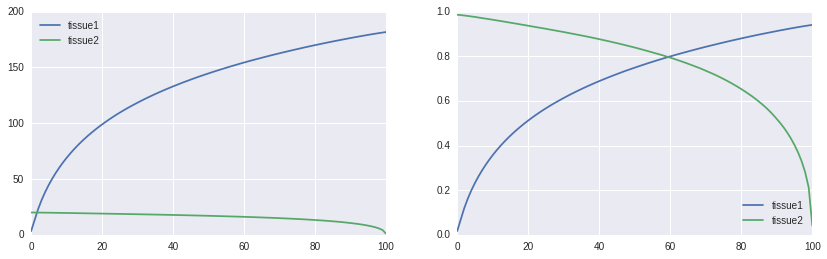

In [342]:
fix, (ax1, ax2) = subplots(1, 2, figsize=(14, 4))
pd.DataFrame(wmw_score).plot(ax=ax1)
pd.DataFrame(wmw_score_corr).plot(ax=ax2)

## $r$ effect size, corrected and uncorrected

In [343]:
r = {
    tissue: [wmw_r(s_mixed[~ind[tissue]], s_mixed[ind[tissue]], u) for u, p in res]
    for s_mixed, (tissue, res) in zip(mixed, wmw_res.items())
}
r_corr = {
    tissue: [wmw_r(s_mixed[~ind[tissue]], s_mixed[ind[tissue]], u) / wmw_exp[tissue][0] for u, p in res]
    for s_mixed, (tissue, res) in zip(mixed, wmw_res.items())
}
r_corr_u = {
    tissue: [wmw_r_corr(s_mixed[~ind[tissue]], s_mixed[ind[tissue]], u, u_exp[tissue]) for u, p in res]
    for s_mixed, (tissue, res) in zip(mixed, wmw_res.items())
}

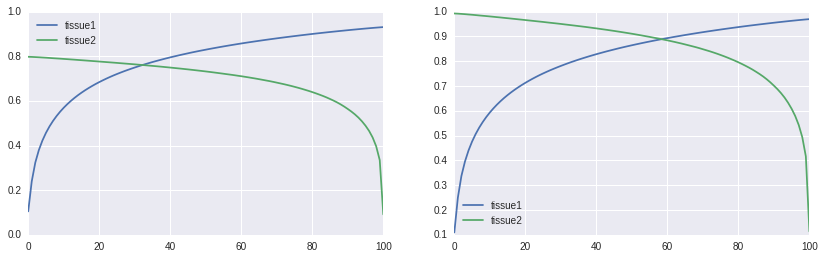

In [344]:
fix, (ax1, ax2) = subplots(1, 2, figsize=(14, 4))
pd.DataFrame(r).plot(ax=ax1)
pd.DataFrame(r_corr).plot(ax=ax2)

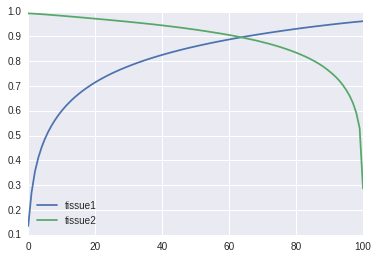

In [345]:
pd.DataFrame(r_corr_u).plot()